In [1]:
import numpy as np
import pandas as pd
import main
fake_data_wc = pd.read_csv('fake_data/fake_wc_res.csv', delimiter=';')
fake_data_wc.head()

,ID,X,Y,WC
0,0,348202,6460000,1.700000e+38
1,1,348202,6460000,1.700000e+38
2,2,348202,6460000,1.700000e+38
3,3,348202,6460000,1.700000e+38
4,4,348202,6460000,1.700000e+38


In [2]:
# Конвертируем форматы
fake_data_wc['WC'] = fake_data_wc['WC'].astype('float64')
fake_data_wc['ID'] = fake_data_wc['ID'].astype('str')
fake_data_wc['WELL_NAME'] = 'fake_' + fake_data_wc['ID']
del fake_data_wc['ID']
fake_data_wc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5399 entries, 0 to 5398
Data columns (total 4 columns):
X            5399 non-null int64
Y            5399 non-null int64
WC           5399 non-null float64
WELL_NAME    5399 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 168.8+ KB


In [3]:
fake_data_wc.describe()

,X,Y,WC
count,5399.000000,5.399000e+03,5.399000e+03
mean,353124.948694,6.465675e+06,2.393036e+36
std,2180.726934,4.954670e+03,2.002907e+37
min,348202.000000,6.460000e+06,1.300000e-01
25%,351602.000000,6.460000e+06,2.700000e-01
50%,353302.000000,6.470000e+06,3.200000e-01
75%,354702.000000,6.470000e+06,3.600000e-01
max,357802.000000,6.470000e+06,1.700000e+38


In [4]:
# Удаляем значения зашедшие за край
fake_data_wc = fake_data_wc.drop(fake_data_wc[fake_data_wc['WC'] > 1].index)
fake_data_wc.describe()

,X,Y,WC
count,5323.000000,5.323000e+03,5323.000000
mean,353157.138080,6.465756e+06,0.318732
std,2158.768029,4.942957e+03,0.070173
min,348302.000000,6.460000e+06,0.130000
25%,351602.000000,6.460000e+06,0.270000
50%,353402.000000,6.470000e+06,0.320000
75%,354802.000000,6.470000e+06,0.360000
max,357802.000000,6.470000e+06,0.620000


In [5]:
fake_las_out = pd.read_csv('fake_data/fake_las_out.csv', delimiter=';')
fake_las_out.head()

,WELL_NAME,DEPTH,APS
0,fake_0,2584.999314,0.380130
1,fake_0,2585.121187,0.380130
2,fake_0,2585.121309,0.364062
3,fake_0,2585.243182,0.364062
4,fake_0,2585.243304,0.309785


In [6]:
fake_bottom = pd.read_csv('fake_data/fake_bottom_res.csv', delimiter=';')
fake_bottom['ID'] = fake_bottom['ID'].astype('str')
fake_bottom['WELL_NAME'] = 'fake_' + fake_bottom['ID']
fake_bottom = fake_bottom.rename(columns={'DEPTH': 'DEPTH_BOTTOM'})
del fake_bottom['ID']
del fake_bottom['X']
del fake_bottom['Y']
fake_bottom.head()

,DEPTH_BOTTOM,WELL_NAME
0,2601.50,fake_0
1,2600.09,fake_1
2,2598.85,fake_2
3,2598.79,fake_3
4,2599.31,fake_4


In [7]:
fake_top = pd.read_csv('fake_data/fake_top_res.csv', delimiter=';')
fake_top['ID'] = fake_top['ID'].astype('str')
fake_top['WELL_NAME'] = 'fake_' + fake_top['ID']
fake_top = fake_top.rename(columns={'DEPTH': 'DEPTH_TOP'})
del fake_top['ID']
del fake_top['X']
del fake_top['Y']
fake_top.head()

,DEPTH_TOP,WELL_NAME
0,2585.02,fake_0
1,2582.98,fake_1
2,2581.22,fake_2
3,2580.52,fake_3
4,2580.87,fake_4


In [8]:
fake_data = pd.merge(fake_data_wc, fake_las_out, on='WELL_NAME')
fake_data = pd.merge(fake_data, fake_top, on='WELL_NAME') 
fake_data = pd.merge(fake_data, fake_bottom, on='WELL_NAME')
fake_data.head()

,X,Y,WC,WELL_NAME,DEPTH,APS,DEPTH_TOP,DEPTH_BOTTOM
0,348302,6460000,0.39,fake_24,2588.656453,0.274434,2588.27,2603.89
1,348302,6460000,0.39,fake_24,2588.771455,0.274434,2588.27,2603.89
2,348302,6460000,0.39,fake_24,2588.771570,0.274434,2588.27,2603.89
3,348302,6460000,0.39,fake_24,2588.886333,0.191055,2588.27,2603.89
4,348302,6460000,0.39,fake_24,2588.886448,0.101674,2588.27,2603.89


In [9]:
print(fake_data['APS'].min())
print(fake_data['APS'].max())

mask_sub_zero = fake_data.APS < 0
mask_above_one = fake_data.APS > 1
column_name = 'APS'
fake_data.loc[mask_sub_zero, column_name] = 0
fake_data.loc[mask_above_one, column_name] = 1

print(fake_data['APS'].min())
print(fake_data['APS'].max())

-0.483299255
1.2203967571
0.0
1.0


In [10]:
from scipy import interpolate
well_name_list = fake_data['WELL_NAME'].value_counts().index.tolist()
x_values = []
y_values = []
count_val = 100
well_count = 0
min_count_val_in_data = 10
for well_name in well_name_list:
    if well_count%500 == 0:
        print(well_count, ' of ', len(well_name_list))
    data_well =  fake_data[fake_data['WELL_NAME'] == well_name]
    bottom = data_well['DEPTH_BOTTOM'].tolist()[0]
    top = data_well['DEPTH_TOP'].tolist()[0]
    # print('top = ', top)
    # print('bottom =', bottom)    
    data_well_by_bound = data_well[(data_well['DEPTH'] >= top) & (data_well['DEPTH'] <= bottom)]
    x_arr = data_well_by_bound['DEPTH']
    y_arr = data_well_by_bound['APS']
    
    if (len(x_arr) < min_count_val_in_data):
            continue
    
    # print ('length of array depth', len(x_arr))
    f_spline = interpolate.interp1d(x_arr, y_arr, kind = 'slinear')
    h_start = data_well_by_bound['DEPTH'].min()
    h_end = data_well_by_bound['DEPTH'].max()
    # print(h_start, h_end, top, bottom)
    h_step = (h_end - h_start)/count_val
    x_temp = []
    i = 0
    while(i < count_val):
        x_temp.append(float(f_spline(h_start + i * h_step)))
        i = i + 1
    x_values.append(x_temp)  
    y_values.append(data_well['WC'].tolist()[0])
    well_count = well_count + 1
#     if well_count == 100:
#         break
print('end fill')

0  of  5322
500  of  5322
1000  of  5322
1500  of  5322
2000  of  5322
2500  of  5322
3000  of  5322
3500  of  5322
4000  of  5322
4500  of  5322
5000  of  5322
end fill


In [13]:
save_x_aps = pd.DataFrame(x_values, columns=['aps' + str(z) for z in range(0, len(x_values[0]))])
save_y_aps = pd.DataFrame(y_values, columns=['wc'])
save_xy_aps = pd.merge(save_y_aps, save_x_aps, left_index = True, right_index = True)

In [14]:
save_xy_aps.to_csv('fake_data/fake_data_collect_aps_1.csv', sep = ';', index = False)

In [15]:
x_values = np.array(x_values)
print(x_values.shape)

y_values = np.array(y_values)
print(y_values.shape)

(5322, 100)
(5322,)


In [16]:
import numpy as np
import pandas as pd
real_las_aps_wc_real = pd.read_csv('fake_data/_aps_real_wc.csv', delimiter=';')
real_las_aps_wc_real.head()

real_las_aps_wc_calc = pd.read_csv('fake_data/_aps_calc_wc.csv', delimiter=';')
real_las_aps_wc_calc.head()

,wc,aps0,aps1,aps2,aps3,aps4,aps5,aps6,aps7,aps8,...,aps90,aps91,aps92,aps93,aps94,aps95,aps96,aps97,aps98,aps99
0,0.137514,0.29,0.2900,0.2900,0.2985,0.4600,0.460,0.46,0.320,0.32,...,0.78,0.78,0.7800,0.78,0.78,0.78,0.78,0.78,0.78,0.78
1,0.348639,0.56,0.5600,0.5056,0.3900,0.3900,0.582,0.63,0.630,0.72,...,0.74,0.74,0.7400,0.74,0.74,0.74,0.74,0.74,0.74,0.74
2,0.418004,0.33,0.3300,0.3300,0.3300,0.3300,0.330,0.33,0.330,0.33,...,0.66,0.38,0.3800,0.56,0.56,0.56,0.56,0.56,0.44,0.44
3,0.330812,0.06,0.0762,0.1500,0.1500,0.2724,0.320,0.32,0.780,0.78,...,0.40,0.40,0.6072,0.77,0.77,0.77,0.77,0.77,0.77,0.77
4,0.319543,0.33,0.3300,0.3300,0.3300,0.5800,0.580,0.58,0.485,0.33,...,0.53,0.53,0.6400,0.64,0.64,0.70,0.70,0.70,0.70,0.70


In [17]:
y_real_wc = real_las_aps_wc_real['wc']
y_real_wc = np.array(y_real_wc)
print(y_real_wc.shape)
del real_las_aps_wc_real['wc']
x_real_wc = np.array(real_las_aps_wc_real)
print(x_real_wc.shape)

(129,)
(129, 100)


In [18]:
y_real_wc_calc = real_las_aps_wc_calc['wc']
y_real_wc_calc = np.array(y_real_wc_calc)
print(y_real_wc_calc.shape)
del real_las_aps_wc_calc['wc']
x_real_wc_calc = np.array(real_las_aps_wc_calc)
print(x_real_wc_calc.shape)

(129,)
(129, 100)


In [19]:
from sklearn.model_selection import train_test_split, StratifiedKFold
x_train, x_hold, y_train, y_hold = train_test_split(x_values, y_values, test_size=0.3, random_state=17)

In [20]:
print(min(y_values))
print(max(y_values))
print(max(y_values) - min(y_values))


print(min(y_real_wc))
print(max(y_real_wc))

print(min(y_real_wc_calc))
print(max(y_real_wc_calc))

0.13
0.62
0.49
0.01
0.84
0.129652
0.622246


In [70]:
del model

In [21]:
from keras.datasets import boston_housing
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Устанавливаем seed для повторяемости результатов
np.random.seed(42)
# Создаем последовательную модель
model = Sequential()

model.add(Dense(250, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(200, activation='relu', input_shape=(250,)))
model.add(Dense(100, activation='relu', input_shape=(200,)))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu', input_shape=(100,)))
model.add(Dense(49, activation='relu', input_shape=(100,)))
model.add(Dense(1))

# Компилируем модель
model.compile(loss="mse", optimizer="adam", metrics=['mae'])

print(model.summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 250)               25250     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               50200     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 49)                4949      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 50        
Total para

In [22]:
# Обучаем сеть
model.fit(x_train, y_train, batch_size=5, nb_epoch=50, verbose=1)

C:\Users\M1\Anaconda3\lib\site-packages\keras\models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/50
3725/3725 [==============================] - 2s 623us/step - loss: 0.0057 - mean_absolute_error: 0.0560
Epoch 2/50
3725/3725 [==============================] - 2s 463us/step - loss: 0.0030 - mean_absolute_error: 0.0429
Epoch 3/50
3725/3725 [==============================] - 2s 481us/step - loss: 0.0027 - mean_absolute_error: 0.0408
Epoch 4/50
3725/3725 [==============================] - 2s 485us/step - loss: 0.0023 - mean_absolute_error: 0.0374
Epoch 5/50
3725/3725 [==============================] - 2s 477us/step - loss: 0.0020 - mean_absolute_error: 0.0344
Epoch 6/50
3725/3725 [==============================] - 2s 517us/step - loss: 0.0019 - mean_absolute_error: 0.0339
Epoch 7/50
3725/3725 [==============================] - 2s 454us/step - loss: 0.0016 - mean_absolute_error: 0.0311
Epoch 8/50
3725/3725 [==============================] - 2s 453us/step - loss: 0.0016 - mean_absolute_error: 0.0307
Epoch 9/50
3725/3725 [==============================] - 2s 411us/step - loss: 0.

In [23]:
y_predict = model.predict(x_hold)
y_real_wc_calc_predict = model.predict(x_real_wc_calc)
y_real_wc_predict = model.predict(x_real_wc)

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def data_analize_func(predict_for_analize, file_name = ''):
    # подготовка данных
    data_for_analize = predict_for_analize.sort_values(by=['y_hold'])
    data_for_analize['x_axis'] = [x for x in range(len(predict_for_analize['y_hold']))]
    data_for_analize.head()
    if file_name != '':
        data_for_analize.to_csv('AllGisParams/' + file_name, index=False, sep = ';')
    
    # построение графиков
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_predict'], color = 'blue')
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_hold'], color = 'red')
    plt.show()
    
    # regression metrics
    print('MSE                      = '+ str(mean_squared_error(data_for_analize['y_hold'], 
                                                                data_for_analize['y_predict'])))
    print('MAE                      = '+ str(mean_absolute_error(data_for_analize['y_hold'], 
                                                                 data_for_analize['y_predict'])))
    print('r2_score                 = '+ str(r2_score(data_for_analize['y_hold'], 
                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')
    print('explained_variance_score = '+ str(explained_variance_score(data_for_analize['y_hold'], 
                                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')

Анализ тестовой вывборки на сгенерированных данных aps


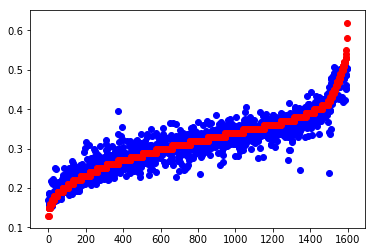

MSE                      = 0.000568869697287
MAE                      = 0.0170435645835
r2_score                 = 0.889038795335    (best_value is 1)
explained_variance_score = 0.88919771463    (best_value is 1)


In [25]:
analize_fake = pd.DataFrame({'y_hold':y_hold, 'y_predict':y_predict[:,0]})

analize_real_wc_calc = pd.DataFrame({'y_hold':y_real_wc_calc, 'y_predict':y_real_wc_calc_predict[:,0]})
analize_real_wc = pd.DataFrame({'y_hold':y_real_wc, 'y_predict':y_real_wc_predict[:,0]})

print('Анализ тестовой вывборки на сгенерированных данных aps')
data_analize_func(analize_fake)

Анализ реальных aps с аппроксимированными значениями wc


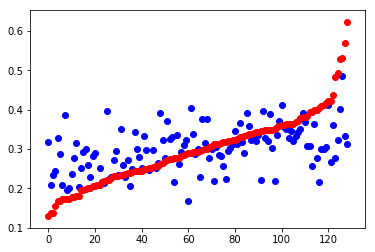

MSE                      = 0.00675833078491
MAE                      = 0.0595461770293
r2_score                 = 0.163711706199    (best_value is 1)
explained_variance_score = 0.163817545813    (best_value is 1)


In [26]:
print('Анализ реальных aps с аппроксимированными значениями wc')
data_analize_func(analize_real_wc_calc)

Анализ реальных aps с реальными значениями wc


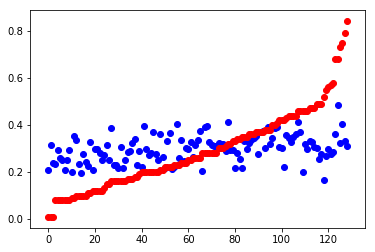

MSE                      = 0.0246917673591
MAE                      = 0.123822980306
r2_score                 = 0.130089315244    (best_value is 1)
explained_variance_score = 0.132547647731    (best_value is 1)


In [27]:
print('Анализ реальных aps с реальными значениями wc')
data_analize_func(analize_real_wc)

In [28]:
# Генерируем описание модели в формате json
model_json = model.to_json()
# Записываем модель в файл
json_file = open("fake_data/fake_aps_model.json", "w")
json_file.write(model_json)
json_file.close()

model.save_weights("fake_data/fake_aps_model.h5")